### 차원 축소
대부분 실무에서 분석하는 데이터는 매우 많은 특성(feature)들을 가지고 있다. 이러한 데이터를 가지고 머신러닝 알고리즘을 적용해 문제를 해결하려고 한다면, 데이터의 차원이 크기 때문에 학습 속도가 느릴 뿐만아니라 성능 또한 좋지않을 가능성이 크다.

이번 장에서는 데이터의 차원을 축소하는 방법인 투영(projection)과 매니폴드 학습(manifold learning)에 대해 알아보도록 하자.

In [7]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

#### 8.1 차원의 저주
머신러닝에서 데이터 셋의 특성(feature)가 많아지면, 각 특성인 하나의 차원(dimension) 또한 증가하게 된다. 이렇게 데이터의 차원이 증가할 수록 데이터 공간의 부피가 기하 급수적으로 증가하기 때문에, 데이터의 밀도는 차원이 증가할 수록 희소(sparse)해진다. 아래의 그림은 데이터의 차원이 증가할수록 각 영역(region)에 포함되는 데이터의 개수를 나타낸 그림(출처: jermwatt's blog)이다. 그림에서 알 수 있듯이 차원이 증가할 수록 데이터의 밀도가 희소해지는것을 알 수 있다.

데이터의 차원이 증가할수록 데이터 포인트 간의 거리 또한 증가하게 되므로, 이러한 데이터를 이용해 머신러닝 알고리즘을 학습 하게되면 모델이 복잡해지게 된다. 따라서, 오버피팅(overfitting) 위험이 커진다.

이러한 차원의 저주를 해결하기 위한 방법 중 하나는 데이터의 밀도가 높아질 때까지 학습 데이터셋의 크기를 늘리는 것이다. 하지만, 데이터셋의 크기에 비해 차원은 기하급수적으로 커지기 때문에 매우 힘든일이라 할 수 있다.

#### 8.2 차원 축소를 위한 접근 방법
8.2 차원 축소를 위한 접근 방법
차원의 저주를 해결하는 방법인 차원을 축소하는 두 가지 접근법인 투영(projection)과 매니폴드 학습(manifold learning)에 대해 알아보도록 하자.

8.2.1 투영 (Projection)
일반적으로 대부분의 실제 데이터셋에서는 모든 데이터의 특성, 즉 차원이 고르게 분포되어 있지 않다. 필기체 숫자 데이터셋인 MNIST를 예로들면, 어떤 특성(각 pixel을 하나의 특성으로 볼 때)은 거의 변화가 없고, 또 어떤 특성은 다른 특성들과 서로 연관되어 있다.

이렇듯 학습 데이터셋은 고차원 공간에서 저차원 부분 공간(subspace)에 위치하게 된다. 즉, 고차원의 데이터의 특성 중 일부 특성으로 데이터를 표현할 수 있다는 말이 된다.

메니폴드 가정은  분류나 회귀같은 작업을 하기전에 학습 데이터셋을 저차원의 매니폴드 공간으로 표현하면 더 간단하게 문제를 해결할 수 있다라는 가정을 할 수 있다.

하지만, 이러한 가정이 항상 통하지는 않는다. 저차원 매니폴드가 오히려 결정 경계(decision boundary)를 찾는 것이 더 어려운 것을 알 수 이다.

따라서, 모델을 학습시키기 전에 학습 데이터셋의 차원을 감소시키면 학습 속도는 빨라지지만 모델의 성능은 항상 더 낫거나 간단한 모델이 되는 것은 아니다. 이것은 데이터셋이 어떠한 모양을 하고 있느냐에 따라 달라진다.

#### 8.3 PCA
주성분 분석(PCA, Principal Component Analysis)은 가장 대표적인 차원 축소 알고리즘이다. PCA는 먼저 데이터에 가장 가까운 초평면(hyperplane)을 구한 다음, 데이터를 이 초평면에 투영(projection)시킨다.

#### 8.3.1 분산 보존
저차원의 초평면에 데이터를 투영하기 전에 먼저 적절한 초평면을 선택해야 한다. PCA는 데이터의 분산이 최대가 되는 축을 찾는다. 즉, 원본 데이터셋과 투영된 데이터셋 간의 평균제곱거리를 최소화 하는 축을 찾는다. 아래의 그림에서 왼쪽 2차원 데이터셋을 오른쪽 그림처럼 투영했을 때 $C_1$축으로 투영한 데이터가 분산이 최대로 보존되는 것을 확인할 수 있다.

#### 8.3.8 압축을 위한 PCA
데이터셋의 차원을 축소하게 되면 데이터셋의 크기가 줄어든다. 다음의 예제는 MNIST 데이터셋에 분산의 95%만 유지하도록 PCA를 적용한 것이다.

In [2]:
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
# MNIST load
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# reshape
train_x = train_x.reshape(-1, 28*28) 

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(train_x)  # PCA 계산 후 투영

print('선택한 차원(픽셀) 수 :', pca.n_components_)

선택한 차원(픽셀) 수 : 154


PCA 적용결과 총 784 차원에서 154로 80%정도 차원이 축소된 것을 알 수 있다. 
이러한 압축한 데이터셋을 이용해 SVM과 같은 분류알고리즘을
학습 시킬 경우 학습 속도를 빠르게 할 수 있다.
또한, 압축된 데이터셋에 PCA 투영 변환을 반대로 적용하여 다시 원 데이터의 차원(mnist 경우 784)로 복원할 수 있다.
위에서 5% 만큼의 정보(분산)을 잃었기 때문에 완벽하게 복원은 할 수 없지만,
원본 데이터와 비슷하게 복원할 수 있다. 이러한 원본 데이터와 복원한 데이터간의
평균 제곱 거리를 재구성 오차(reconstruction error)라고 한다. 

#### 8.3.9 Incremental PCA (IPCA)
PCA의 단점은 SVD(scikit-learn에서)를 수행하기 위해서는 전체 학습 데이터셋을 메모리에 올려야 한다는 것이다. 이러한 단점을 보완하기 위해 Incremental PCA(IPCA) 알고리즘이 개발되었다.

IPCA는 학습 데이터셋을 미니배치로 나눈 뒤 IPCA 알고리즘에 하나의 미니배치를 입력으로 넣어준다. IPCA는 학습 데이터셋이 클때 유용하다.

Scikit-Learn에서는 IncrementalPCA를 통해 Incremental PCA를 사용할 수 있다. 아래의 예제는 MNIST 데이터를 100개의 미니배치로 나눠 PCA를 수행하는 코드이다.

ValueError: cannot reshape array of size 3 into shape (28,28)

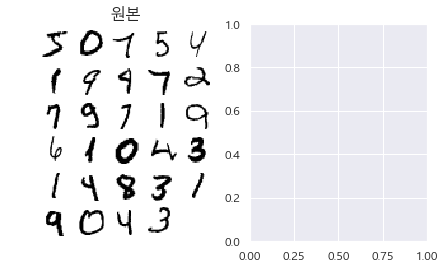

In [12]:
X_recovered = pca.inverse_transform(X_reduced)
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("압축 후 복원", fontsize=16)
plot_digits(X_recovered[::2100])

In [ ]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import matplotlib.pylab as plt
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for batch_x in np.array_split(train_x, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(batch_x)

X_reduced = inc_pca.transform(train_x)

X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

#### 8.3.9 랜덤 PCA
Scikit-Learn의 PCA에서는 Randomized PCA를 제공한다. 이 방법은 첫 $d$개의 주성분에 대해 근사값을 빠르게 찾는다.

#### 8.4 Kernel PCA
'서포트벡터머신, SVM'에서 커널을 이용해 데이터를 저차원에서 고차원으로 매핑시켜 비선형 데이터셋에 SVM을 적용시키는 Kernel SVM에 대해 알아보았다.

이렇게 같은 기법을 PCA에 적용해 비선형 투영으로 차원을 축소할 수 있는데, 이것을 Kernel PCA(KPCA)라고 한다. Scikit-Learn의 KernelPCA를 통해 Kernel PCA를 적용할 수 있다.

In [10]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

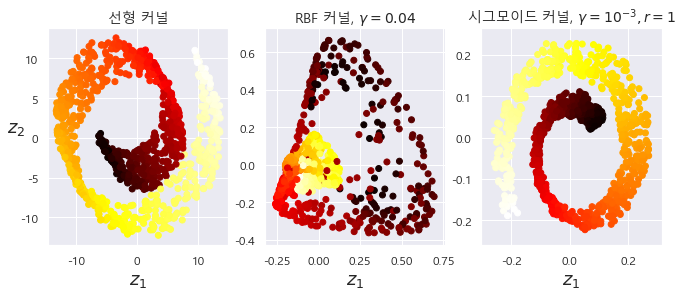

In [11]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "선형 커널"), (132, rbf_pca, "RBF 커널, $\gamma=0.04$"), (133, sig_pca, "시그모이드 커널, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()